In [1]:
import calendar
import time
import datetime
import pandas as pd
import numpy as np
import stanager.observer as so
import stanager.scheduling as ss
import pandas as pd
import itchat as ic
import stanager.communicate as sc
import matplotlib.pyplot as plt
from matplotlib import animation, font_manager
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
# for windows
sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
# for mac
# myfont = font_manager.FontProperties(fname="/Library/Fonts/Songti.ttc")#"/Library/Fonts/Songti.ttc"
# sns.set(font=myfont.get_name())
%matplotlib inline

# observer模块观察学习进度

## 读取表格

每天早上往列表后面更新日期，读取表格之后检查名字、顺序等。

In [37]:
cohort = '0123_AIPND_Lite_5'
dates = ['20190124', '20190125', '20190126', '20190127', '20190128', '20190129',
         '20190130', '20190131', '20190201', '20190202']
date = dates[-1]
students = so.read_students('./{}/students_{}.txt'.format(cohort, date))[:7] #读取表格。取7人为例
cohort_size = students.shape[0]
# students[['Name']]

有些学员在网站上使用的名字与微信昵称不同，咱们可以按顺序替换成我们认识的名字（微信昵称或备注）。然后保存成csv。

In [38]:
Name = ['宋远桥', '俞莲舟', '俞岱岩', '张松溪', '张翠山', '殷梨亭', '莫声谷']
students['Name'] = Name
date_current = ss.parse_time(date, '%Y%m%d').strftime('%Y-%m-%d')
students.insert(value=date_current, loc=2, column='Date')
students.to_csv('./{}/students_{}.csv'.format(cohort, date), encoding='utf_8_sig', index=False)

## 汇总每天数据

下面将所有数据都append起来，整理成一个总表。先初始化，即读取第一天的数据。

**第一天用以下的方法：**

In [39]:
# students_total = students
# students_total.to_csv('./{}/students_total.csv'.format(cohort), encoding='utf_8_sig', index=False)

**第二天以后在第一天的基础上累加：**

In [40]:
students_total = pd.read_csv('./{}/students_total.csv'.format(cohort))
students_total = students_total.append(students)
students_total.reset_index(drop=True, inplace=True)
students_total.to_csv('./{}/students_total.csv'.format(cohort), encoding='utf_8_sig', index=False)
print(students_total.shape[0]/cohort_size == len(dates))
# students_total

False


## 画图

画图还是习惯用R。不过练练Python也好。

先画班级总体的每天学习进展。

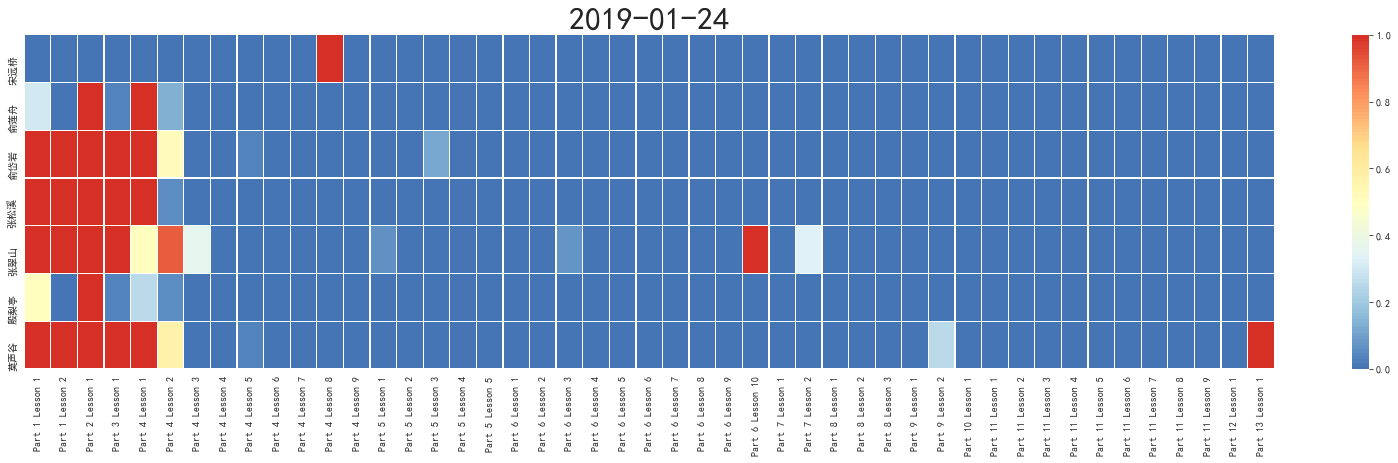

In [42]:
clist = [(0.27, 0.46, 0.71), (0.57, 0.75, 0.86), (0.88, 0.95, 0.97), (1, 1, 0.75), (1, 0.88, 0.56), (0.99, 0.55, 0.35), (0.84, 0.19, 0.15)]
pal = LinearSegmentedColormap.from_list(name = None, colors = clist, N=100)
f = plt.figure(figsize=(28, 8))
def init():
    idx = list(filter(lambda x: students_total['Date'][x] == students_total['Date'].unique()[0], students_total.index.tolist()))
    data = students_total.iloc[idx, :]
    f = sns.heatmap(data.iloc[:, list(range(3, 50))], cmap= pal, linecolor='white', linewidths=0.3, cbar=False,
                    yticklabels=data['Name'],annot_kws={'size': 20});
    plt.title(data['Date'].unique()[0], fontdict={'fontsize': 32})
    plt.subplots_adjust(bottom=0.3)
    return f


def animate(i):
    plt.clf()
    idx = list(filter(lambda x: students_total['Date'][x] == i, students_total.index.tolist()))
    data = students_total.iloc[idx, :]
    f = sns.heatmap(data.iloc[:, list(range(3, 50))], cmap= pal, linecolor='white', linewidths=0.3, yticklabels=data['Name'],annot_kws={'size': 20});
    plt.title(data['Date'].unique()[0], fontdict={'fontsize': 32})
    plt.subplots_adjust(bottom=0.3)
    return f,

ani = animation.FuncAnimation(fig=f, func=animate, frames=students_total['Date'].unique(), init_func=init,
                              interval=1000, blit=False, repeat = True, repeat_delay = 200)

ani.save('./{}/students_progress.gif'.format(cohort), writer='pillow')
plt.show()

**TODO：动图在jupyter上不动的原因再找找。输出gif没问题。**

下面是每个人的学习进展，可以看出一个学生在某个内容上的滞留时间。

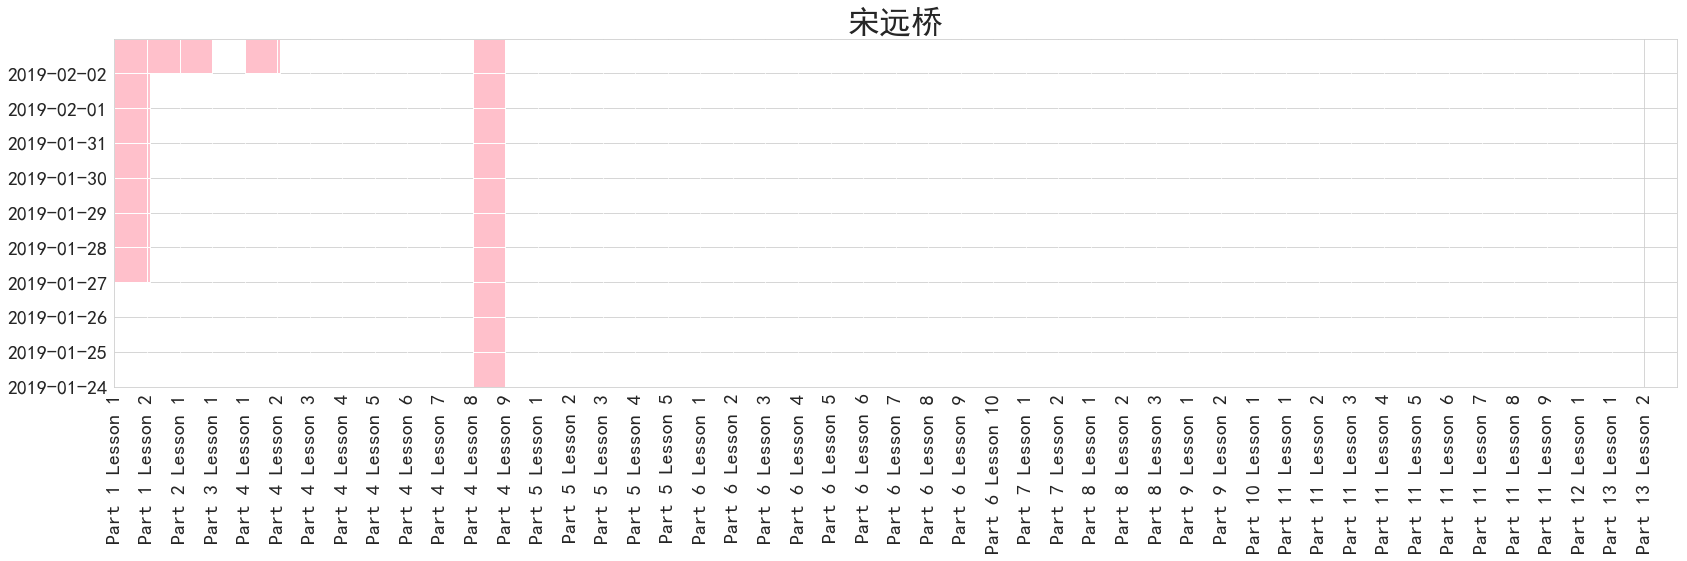

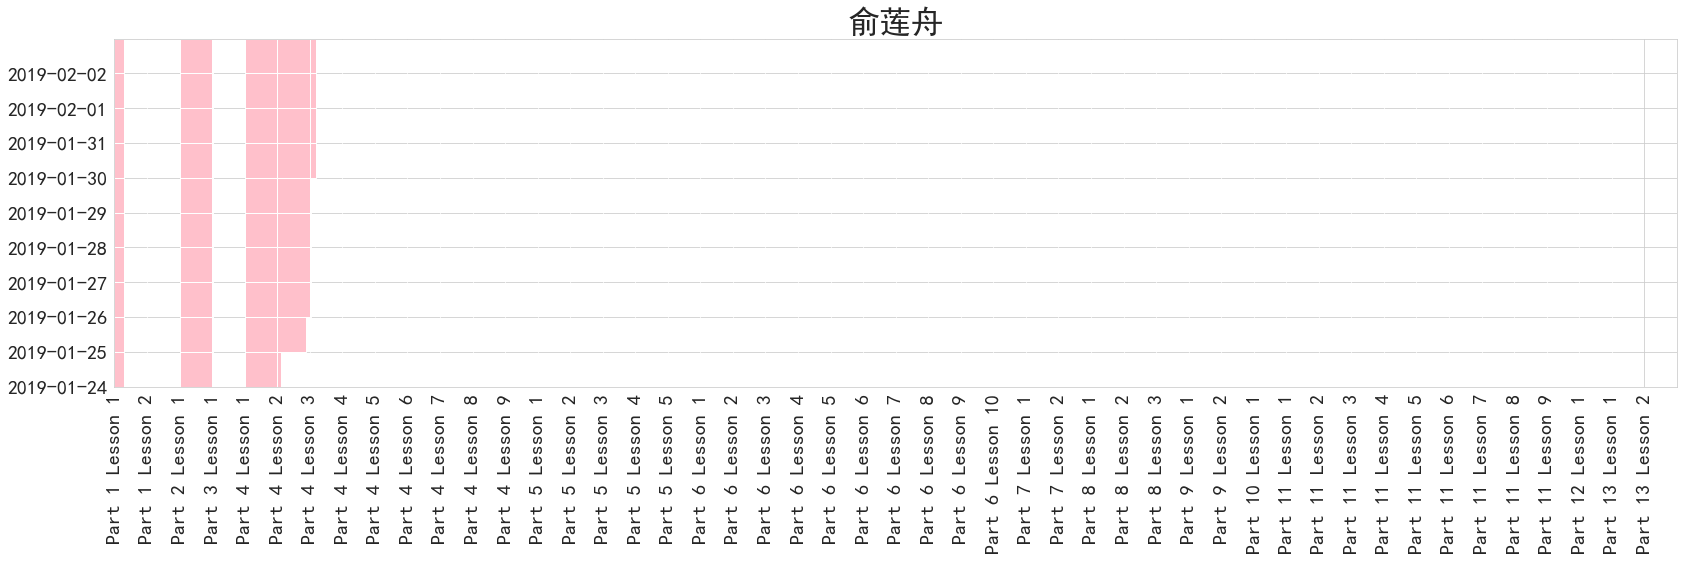

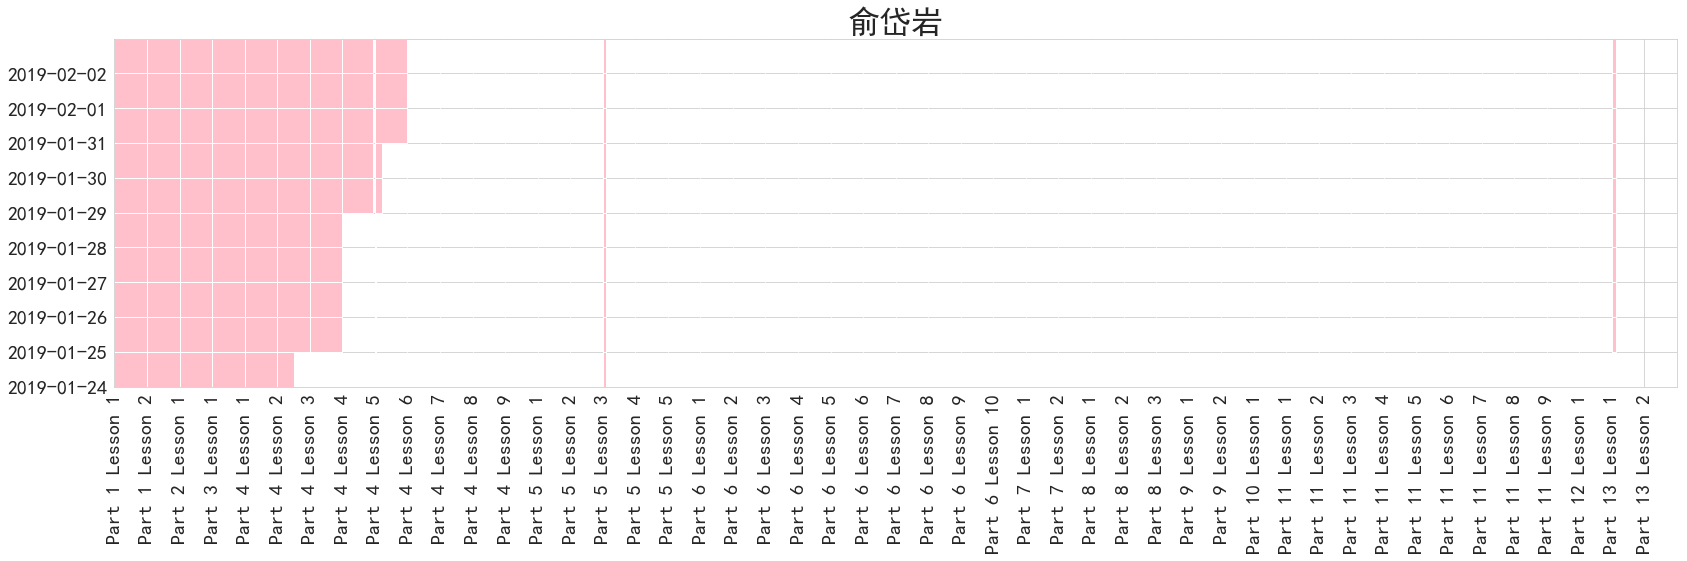

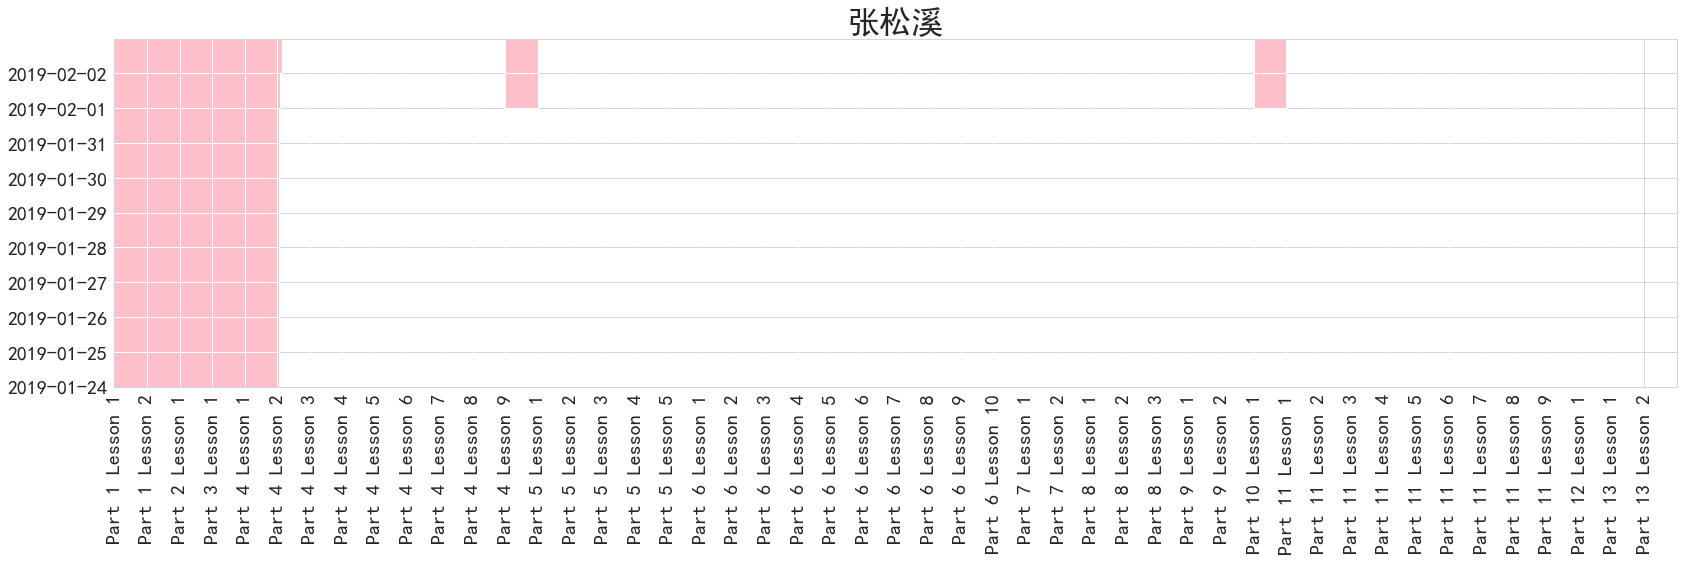

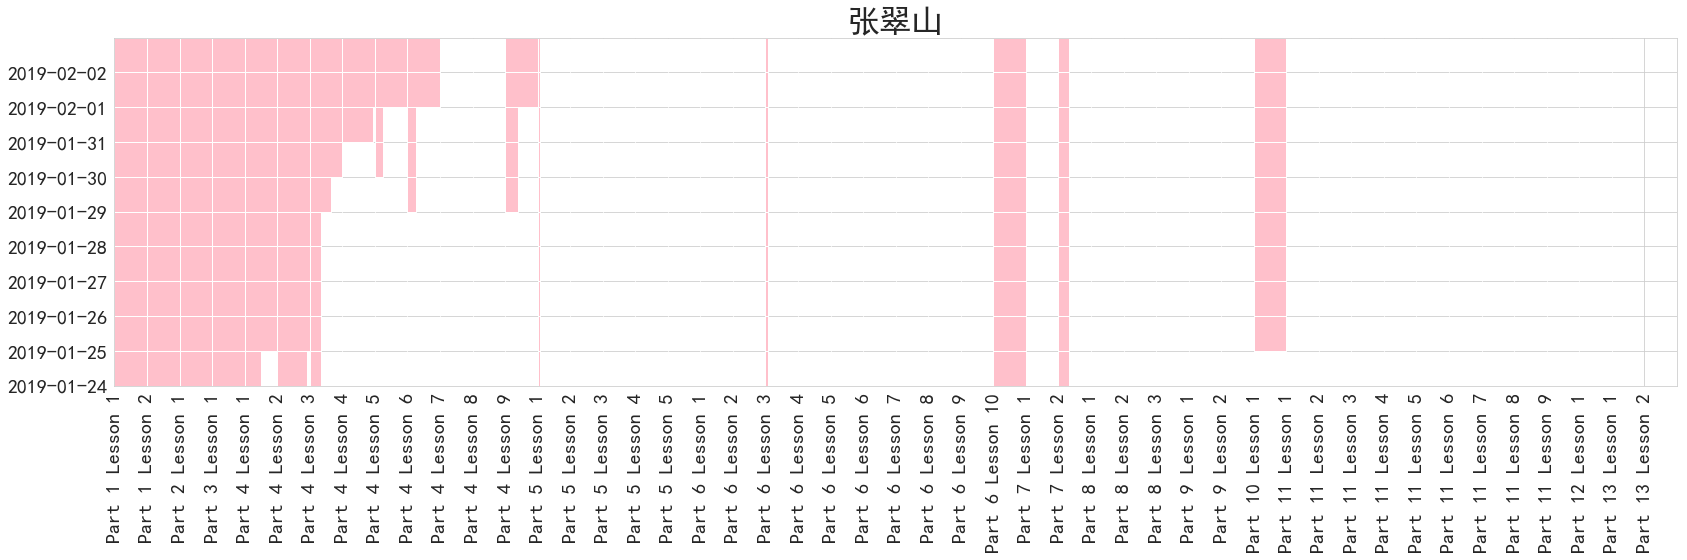

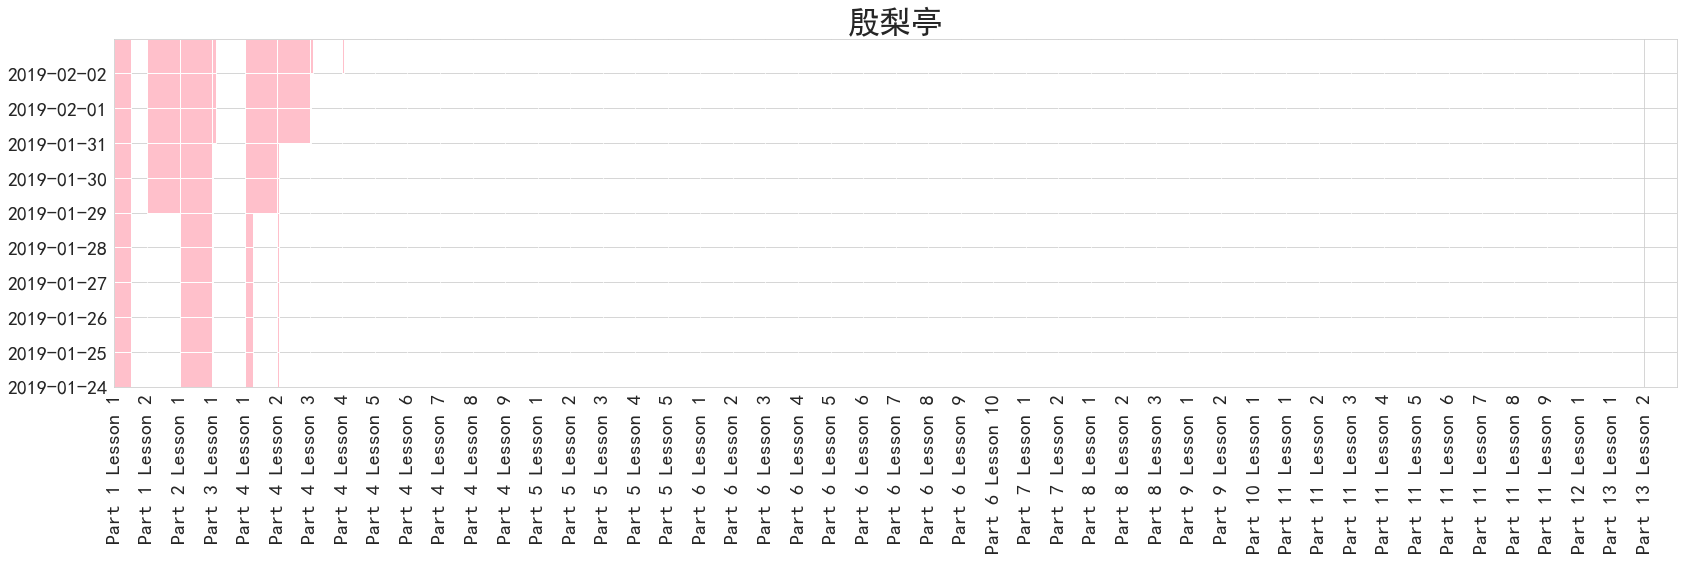

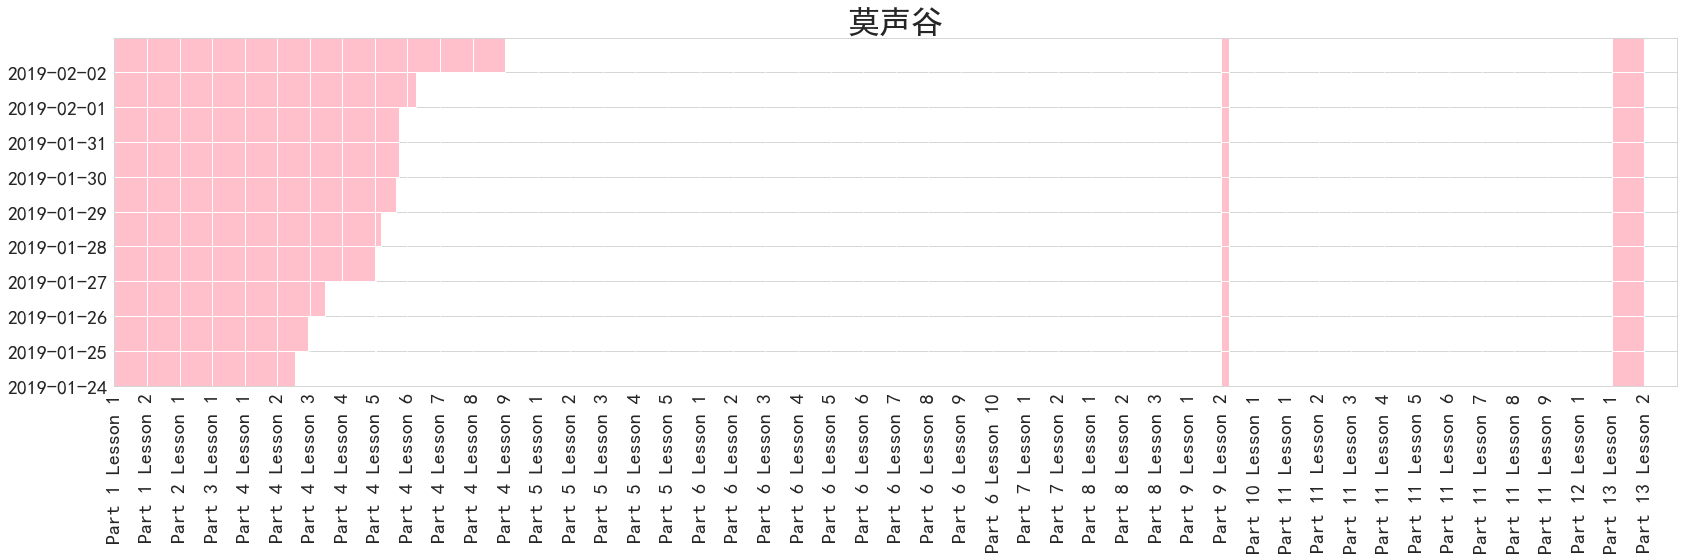

In [43]:
stunames = students_total['Name'].unique()
# with PdfPages('./{}/personal_progress.pdf'.format(cohort)) as pdf:
for stuname in stunames:
    stu_pos = list(filter(lambda x: students_total['Name'][x] == stuname, students_total.index.tolist()))[0]
    fig, ax = plt.subplots(figsize=(28, len(students_total['Date'].unique())/1.2))
    for d in list(range(len(students_total['Date'].unique()))):
        yrange = (d, 1)
        xranges = list(zip(list(range(len(students_total.columns[3:]))), 
                           students_total.iloc[stu_pos+cohort_size*d:stu_pos+1+cohort_size*d, list(range(3, 50))].values[0].tolist()))
        ax.broken_barh(yrange = yrange, xranges = xranges, facecolors='pink')
    ax.set_ylim(0, len(set(students_total['Date'])))
    ax.set_yticks(range(len(students_total['Date'].unique())))
    ax.set_yticklabels(students_total['Date'].unique(), fontdict={'fontsize': 20})
    ax.set_xlim(0, len(students_total.columns[3:]))
    ax.set_xticks(range(len(students_total.columns[3:])))
    ax.set_xticklabels(students_total.columns[3:].values, rotation = 90, fontdict={'fontsize': 20})
    ax.grid(True)
    plt.title(stuname, fontdict={'fontsize': 32})
    plt.subplots_adjust(bottom=0.3)
#     pdf.savefig()
#     plt.close()

## 记录通关状态

把项目通关状态做成字典然后assign进表格里。

In [44]:
projects = ['Part 4 Lesson 8', 'Part 5 Lesson 5', 'Part 6 Lesson 10', 'Part 9 Lesson 2'] # 由于系统数据并不显示哪一节是项目，所以要手动查找记录
status = {'Passed': {'张松溪': projects[:2],
                     '张翠山': projects[:1],
                     '莫声谷': projects[:1],
                     '宋远桥': projects[:1],
                     '俞莲舟': projects[:1],
                     '莫声谷': projects[:1],
                     '殷梨亭': projects[:1],
                    },
          'In Review': {'俞岱岩': projects[:1]}
         }
for sta, stu  in status.items():
    for passer in stu:
        so.assign_status(students, passer, stu[passer], sta)

In [45]:
students.to_csv('./{}/students_{}.csv'.format(cohort, date), encoding='utf_8_sig', index=False)

# scheduling排课模块

## 定义课节

In [46]:
JYZJ = ss.Classes('九阴真经', duration=40)

## 定义讲师

In [47]:
start_1 = '2019-02-03 19:00'
end_1 = '2019-02-03 21:00'
start_2 = '2019-02-05 19:00'
end_2 = '2019-02-05 21:00'
qiu_chuji = ss.Mentor(name = '邱处机', available = [(start_1, end_1),
                                             (start_2, end_2)])
print('讲师姓名：{}'.format(qiu_chuji.name))
print('讲师可排课时间：{}'.format(qiu_chuji.available))

讲师姓名：邱处机
讲师可排课时间：[('2019-02-03 19:00', '2019-02-03 21:00'), ('2019-02-05 19:00', '2019-02-05 21:00')]


## 定义学生

定义学生杨康

In [48]:
yang_kang = ss.Student('杨康', [('2019-02-03 14:00', '2019-02-03 18:00'),
                         ('2019-02-03 20:00', '2019-02-03 22:00'),
                         ('2019-02-05 20:00', '2019-02-05 22:00')])

定义学生杨过

In [49]:
yang_guo = ss.Student('杨过', [('2019-02-03 20:00', '2019-02-03 22:00'),
                         ('2019-02-05 14:00', '2019-02-05 16:00'),
                         ('2019-02-05 20:00', '2019-02-05 22:00')])

## 预约课程

首次预约课程：

In [50]:
qiu_chuji.init_appointment(JYZJ, yang_kang, start= '2019-02-03 19:30')
print('{}老师，你的课程表如下：\n{}\n请提前做好准备！'.format(qiu_chuji.name, qiu_chuji.schedule))
print('老师的剩余可用时间为\n{}'.format(qiu_chuji.available))

没问题，该时间段内老师可排课！
邱处机老师，你的课程表如下：
{'杨康': [('2019-02-03 19:30', '2019-02-03 20:10')]}
请提前做好准备！
老师的剩余可用时间为
[('2019-02-03 19:00', '2019-02-03 19:30'), ('2019-02-03 20:10', '2019-02-03 21:00'), ('2019-02-05 19:00', '2019-02-05 21:00')]


另一个学生的首次预约课程：

In [51]:
qiu_chuji.init_appointment(JYZJ, yang_guo, start= '2019-02-03 20:20')
print('{}老师，你的课程表如下：\n{}\n请提前做好准备！'.format(qiu_chuji.name, qiu_chuji.schedule))
print('老师的剩余可用时间为\n{}'.format(qiu_chuji.available))

没问题，该时间段内老师可排课！
邱处机老师，你的课程表如下：
{'杨康': [('2019-02-03 19:30', '2019-02-03 20:10')], '杨过': [('2019-02-03 20:20', '2019-02-03 21:00')]}
请提前做好准备！
老师的剩余可用时间为
[('2019-02-03 19:00', '2019-02-03 19:30'), ('2019-02-03 20:10', '2019-02-03 20:20'), ('2019-02-05 19:00', '2019-02-05 21:00')]


杨康同学要排第二节课：

In [52]:
qiu_chuji.init_appointment(JYZJ, yang_kang, start= '2019-02-05 20:20')
print('{}老师，你的课程表如下：\n{}\n请提前做好准备！'.format(qiu_chuji.name, qiu_chuji.schedule))
print('老师的剩余可用时间为\n{}'.format(qiu_chuji.available))

没问题，该时间段内老师可排课！
邱处机老师，你的课程表如下：
{'杨康': [('2019-02-03 19:30', '2019-02-03 20:10'), ('2019-02-05 20:20', '2019-02-05 21:00')], '杨过': [('2019-02-03 20:20', '2019-02-03 21:00')]}
请提前做好准备！
老师的剩余可用时间为
[('2019-02-03 19:00', '2019-02-03 19:30'), ('2019-02-03 20:10', '2019-02-03 20:20'), ('2019-02-05 19:00', '2019-02-05 20:20')]


杨康同学要请假调课：

In [53]:
qiu_chuji.change_appointment(yang_kang, 0, '2019-02-05 19:00')
print('{}老师，你的课程表如下：\n{}\n请提前做好准备！'.format(qiu_chuji.name, qiu_chuji.schedule))
print('老师的剩余可用时间为\n{}'.format(qiu_chuji.available))

没问题，该时间段内老师可排课！
邱处机老师，你的课程表如下：
{'杨康': [('2019-02-05 19:00', '2019-02-05 19:40'), ('2019-02-05 20:20', '2019-02-05 21:00')], '杨过': [('2019-02-03 20:20', '2019-02-03 21:00')]}
请提前做好准备！
老师的剩余可用时间为
[('2019-02-03 19:00', '2019-02-03 20:10'), ('2019-02-05 19:00', '2019-02-05 20:20')]


杨康同学的课程表：

In [54]:
yang_kang.schedule = qiu_chuji.schedule[yang_kang.name]
yang_kang.schedule

[('2019-02-05 19:00', '2019-02-05 19:40'),
 ('2019-02-05 20:20', '2019-02-05 21:00')]

杨过同学的课表：

In [55]:
yang_guo.schedule = qiu_chuji.schedule[yang_guo.name]
yang_guo.schedule

[('2019-02-03 20:20', '2019-02-03 21:00')]

## TODO

* 一个学生如何匹配合适的老师？

* 如何找到一段合适的上课时间？

## TODO：排课表release版

In [56]:
start = '2019-03-27'
end = '2019-06-26'

In [57]:
daterange = ss.date_range(start, end)
parsed_start = ss.parse_time(start, str_format = '%Y-%m-%d')
calendar.weekday(parsed_start.year, parsed_start.month, parsed_start.day)
sch_day = []
target = calendar.weekheader(3).split(' ').index('Tue')
for i in range(6, len(daterange),7):
    sch_day.append(daterange[i])
sch_day[:12]

['2019-04-02',
 '2019-04-09',
 '2019-04-16',
 '2019-04-23',
 '2019-04-30',
 '2019-05-07',
 '2019-05-14',
 '2019-05-21',
 '2019-05-28',
 '2019-06-04',
 '2019-06-11',
 '2019-06-18']

# communicate模块，群发个性化学习任务

## 登录微信

In [58]:
ic.auto_login()

Getting uuid of QR code.
Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as Udacity-Tyelcie


## 读取任务列表

根据每个人当前的进度，制定了不同的任务，然后私信发给各位同学。用`pd.read_csv`或`pd.read_excel`也行，但一般都存在设密的石墨文档上，转存也有点麻烦。所以干脆把要抓的内容选中，Ctrl+C，然后用`pd.read_clipboard()`从剪贴板读取数据。

In [59]:
students = pd.read_clipboard(sep='\t')
students

,姓名,Task 0,Task 1,Task 2
0,Lucifer,九阴真经上卷,九阴真经下卷,亢龙有悔
1,Tyelcie,九阴真经下卷,真经后面的小诗,桃花落英掌


如果要群发消息，注意检查任务序列和消息模板：

In [60]:
task_seq = 'Task 2'
msg_template = 'Hello，{}同学，接下来三天你需要完成的任务是：\n\n{}'
sc.send_task_group(task_seq, msg_template, students)

如果需要单独发消息，注意修改学生姓名、任务序列和消息模板：

In [61]:
student = 'Tyelcie'
task_seq = 'Task 2'
msg_template = 'Hello，{}同学，接下来三天你需要完成的任务是：\n\n{}'
sc.send_task_personal(student, task_seq, msg_template, students)

LOG OUT!


暂时就这样。